Basically 02a but with additional considerations for a high resolution 3D MP-RAGE dataset

In [23]:
## Set up
# module loading
import importlib

# computing
import numpy as np
import sigpy as sp
import sigpy.mri as mr

# file-loading
import os
import scipy as scp
import h5py

# performance evaluation
import time
import tqdm

# plotting
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# custom convenience functions
from utils.plotting import mid3views

# Set-up plots
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['figure.dpi'] = 128

# GPU choice
gpu_id = 3

In [2]:
## Load some data
dataType = '3D'
fn_3d = '/mnt/storage/rexfung/mprageTestData/mprage_3d.mat'
h5file = h5py.File(fn_3d)
ksp = h5file.get('ksp')[()] # (coil, kz, ky, kx)
ksp = ksp['real'] + 1j*ksp['imag'] # convert each element (tuple of real and imag) to complex 64
h5file.close()

Ncoils, Nz, Ny, Nx = ksp.shape # convenience vars

In [3]:
## Retrospectively 9x undersample data with CAIPI pattern
if dataType == '2D':
    mask = np.zeros([Ny, Nx]); # ky, kx for 2D
    Rx = 3
    Ry = 3
    for shift_y in range(Ry):
        mask[shift_y:None:Ry,shift_y*Rx:None:Rx*Ry] = 1
if dataType == '3D':
    mask = np.zeros([Nz, Ny, Nx]) # kz, ky, kx for 3D
    Ry = 3
    Rz = 3
    for shift_z in range(Rz):
        mask[shift_z:None:Rz,shift_z*Ry:None:Ry*Rz,:] = 1
ksp_us = mask * ksp
print('Sampling rate: ', np.sum(mask)/np.size(mask))

if dataType == '2D':
    plt.figure()
    plt.imshow(mask, cmap='autumn')
    plt.title('Sampling mask')
    plt.xlabel('kx')
    plt.ylabel('ky')
elif dataType == '3D':
    plt.figure()
    plt.imshow(mask[:,:,0], cmap='autumn')
    plt.title('Sampling mask (spokes in kx)')
    plt.xlabel('ky')
    plt.ylabel('kz')

del mask

Sampling rate:  0.1119842529296875


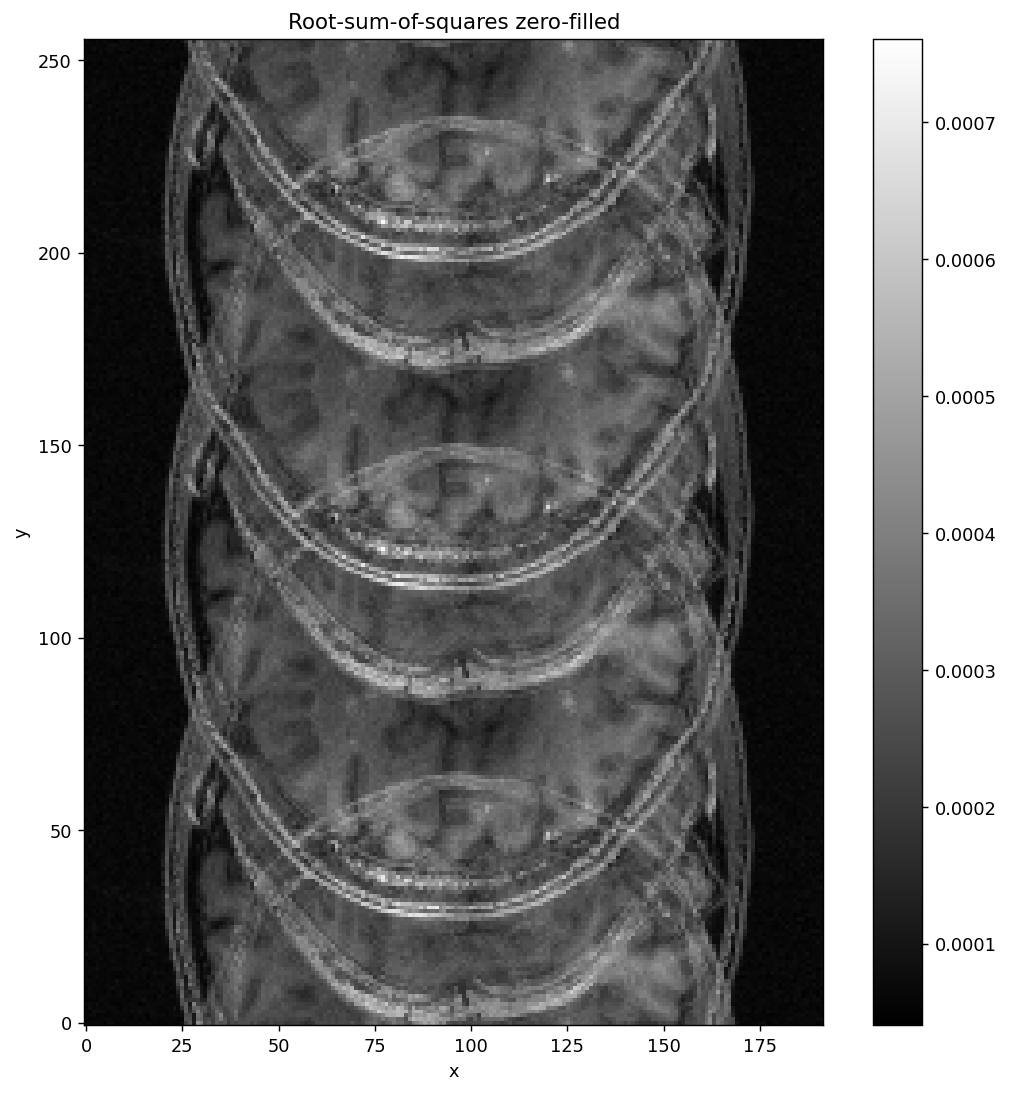

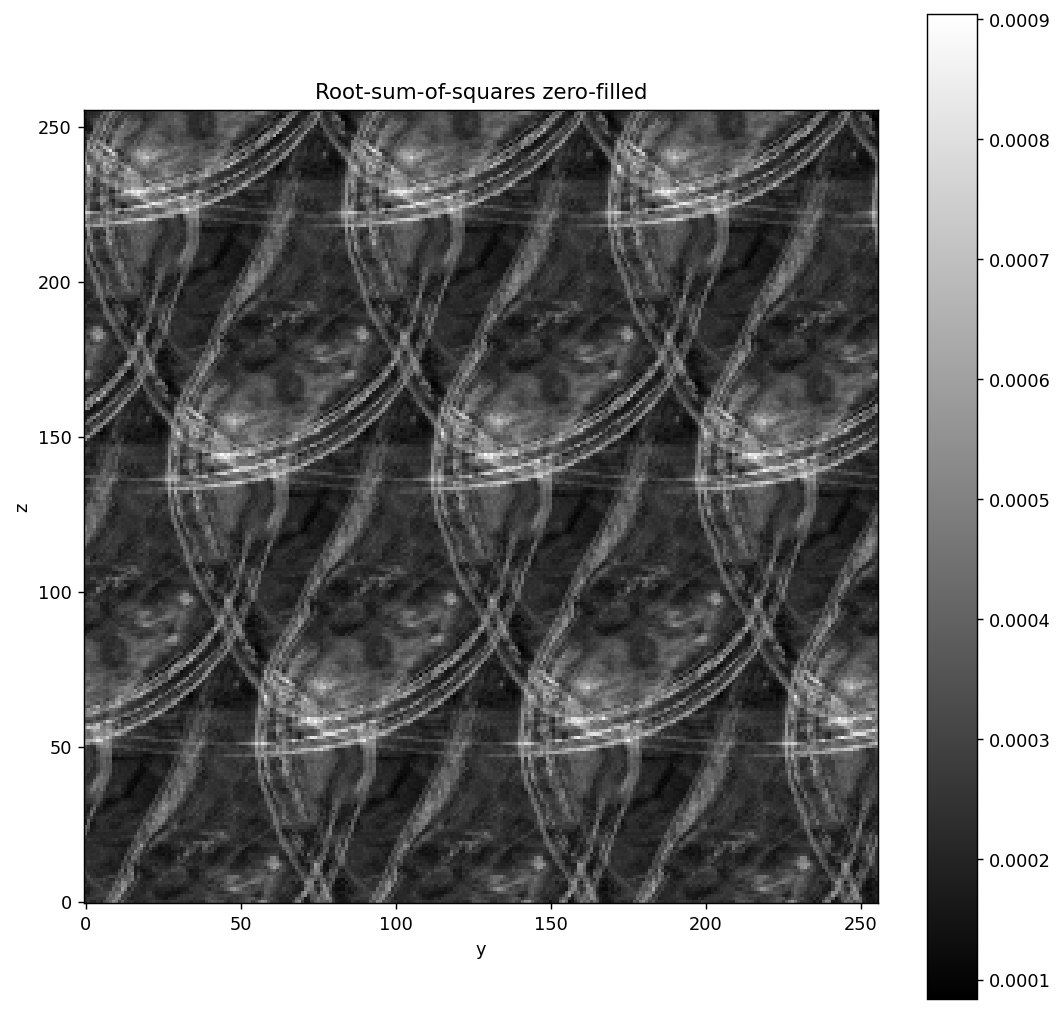

In [4]:
## Show aliasing from undersampled data
img_rss = np.sum(np.abs(sp.ifft(ksp_us, axes=(1, 2, 3)))**2, axis=0)**0.5
img_rss /= np.linalg.norm(img_rss)

if dataType == '2D':
    plt.figure()
    plt.imshow(img_rss, cmap='gray', origin='lower')
    plt.title('Root-sum-of-squares Zero-filled')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()
elif dataType == '3D': # show the middle 3 views of the image
    mid3views(img_rss, 'Root-sum-of-squares zero-filled')

del img_rss

In [11]:
## Estimate sensitivity maps
fn_mps_3d = '/mnt/storage/rexfung/mprageTestData/mprage_3d_mps.mat'

if dataType == '2D':
    mps = mr.app.EspiritCalib(ksp).run()
elif dataType == '3D':
    if os.path.isfile(fn_mps_3d): # load in smaps if they already exist
        h5file = h5py.File(fn_mps_3d)
        mps = h5file.get('mps')[()] # (coil, kz, ky, kx)
        h5file.close()
    else: 
        start = time.time()

        # compute smaps per slice along z.
        mps = np.zeros_like(ksp)
        hybrid_ksp = sp.ifft(ksp, axes=(1,)) # coil, z, ky, kx
        for z in tqdm.trange(Nz):
            mps[:,z,:,:] = mr.app.EspiritCalib(hybrid_ksp[:,z,:,:],device=gpu_id,show_pbar=False).run().get()
        
        end = time.time()
        print(f"Time elapsed: {end - start}")

        # save smaps for next time
        h5file = h5py.File(fn_mps_3d, 'w')
        h5file.create_dataset('mps', data=mps)
        h5file.close()

# 3D times:
# Quickstep GPU (device=3, 4x RTX 2080 Ti): 456 seconds

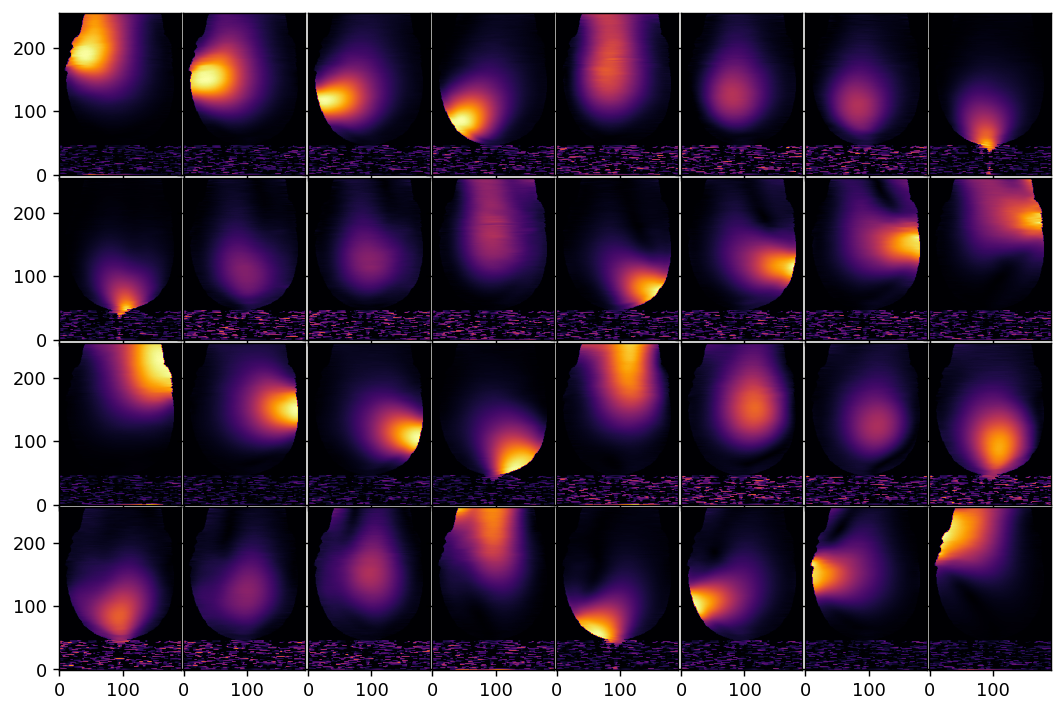

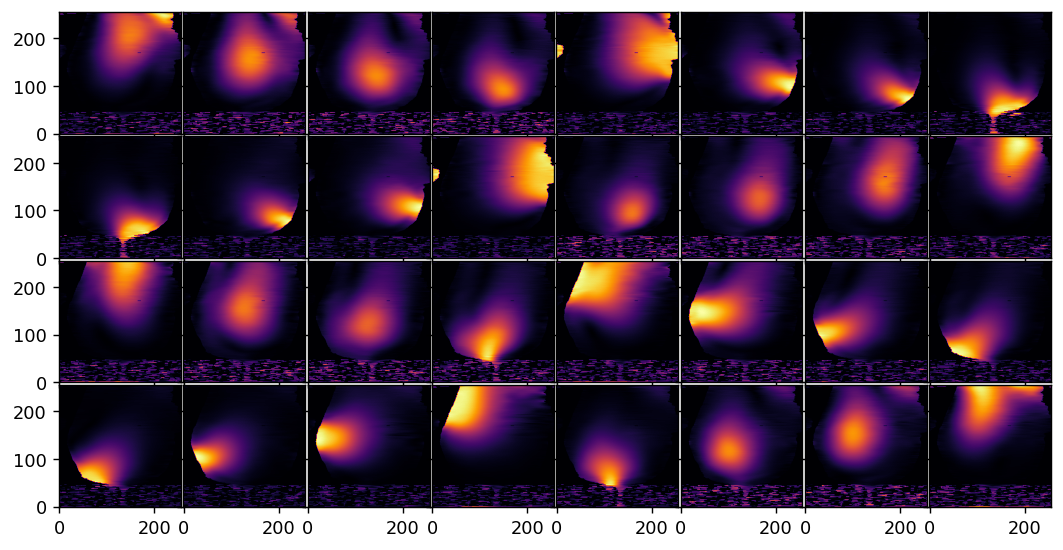

In [12]:
## Display sensitivity maps
if dataType == '2D':
    fig = plt.figure()
    grid = ImageGrid(fig,111,nrows_ncols=(4,8))
    for coil in range(Ncoils):
        grid[coil].imshow(np.abs(mps[coil,:,:]),cmap='inferno',origin='lower')
    plt.show()
elif dataType == '3D':
    fig_ax = plt.figure()
    grid_ax = ImageGrid(fig_ax,111,nrows_ncols=(4,8))
    for coil in range(Ncoils):
        grid_ax[coil].imshow(np.abs(mps[coil,mps.shape[1]//2,:,:]),cmap='inferno',origin='lower')
    plt.show()

    fig_cor = plt.figure()
    grid_cor = ImageGrid(fig_cor,111,nrows_ncols=(4,8))
    for coil in range(Ncoils):
        grid_cor[coil].imshow(np.abs(mps[coil,:,mps.shape[2]//2,:]),cmap='inferno',origin='lower')
    plt.show()

    fig_sag = plt.figure()
    grid_sag = ImageGrid(fig_sag,111,nrows_ncols=(4,8))
    for coil in range(Ncoils):
        grid_sag[coil].imshow(np.abs(mps[coil,:,:,mps.shape[3]//2]),cmap='inferno',origin='lower')
    plt.show()

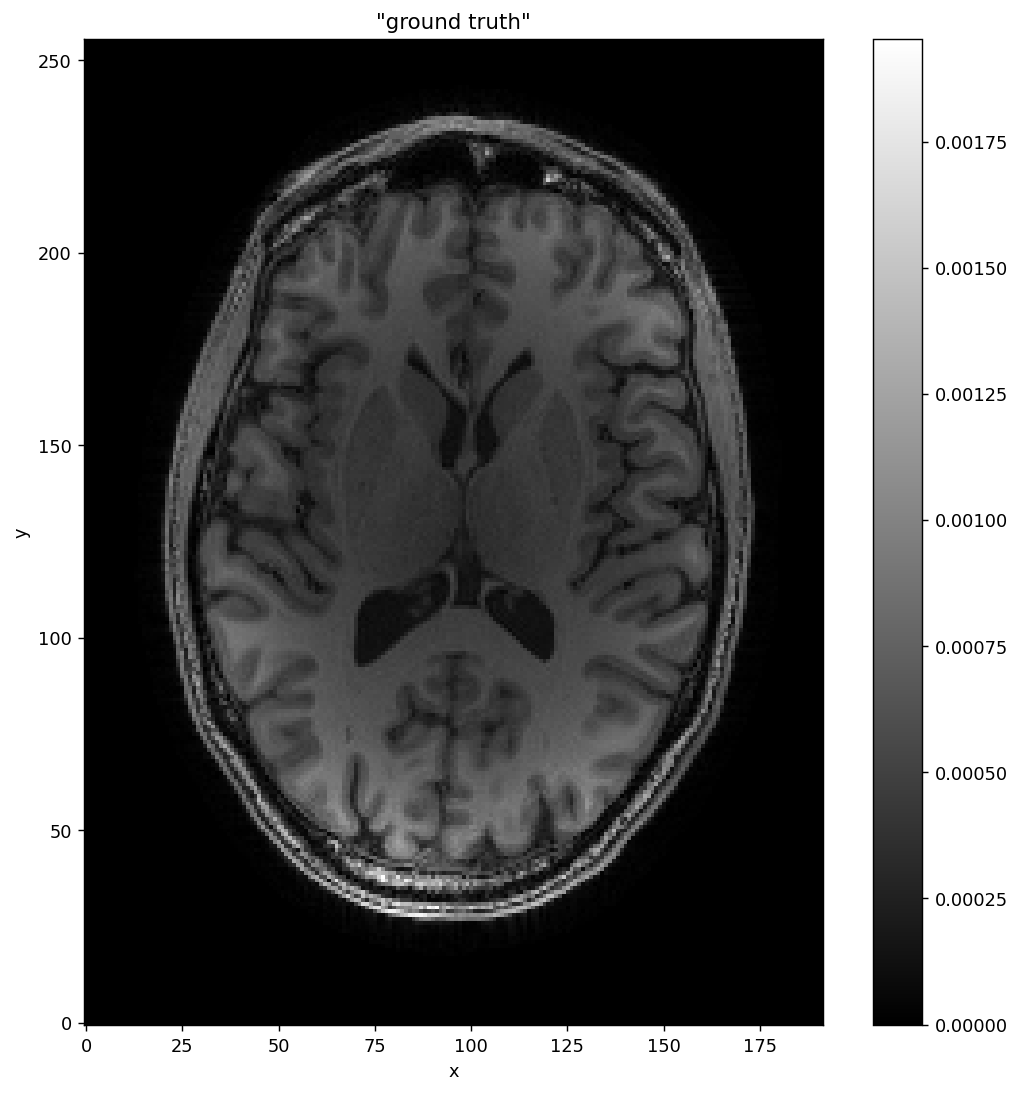

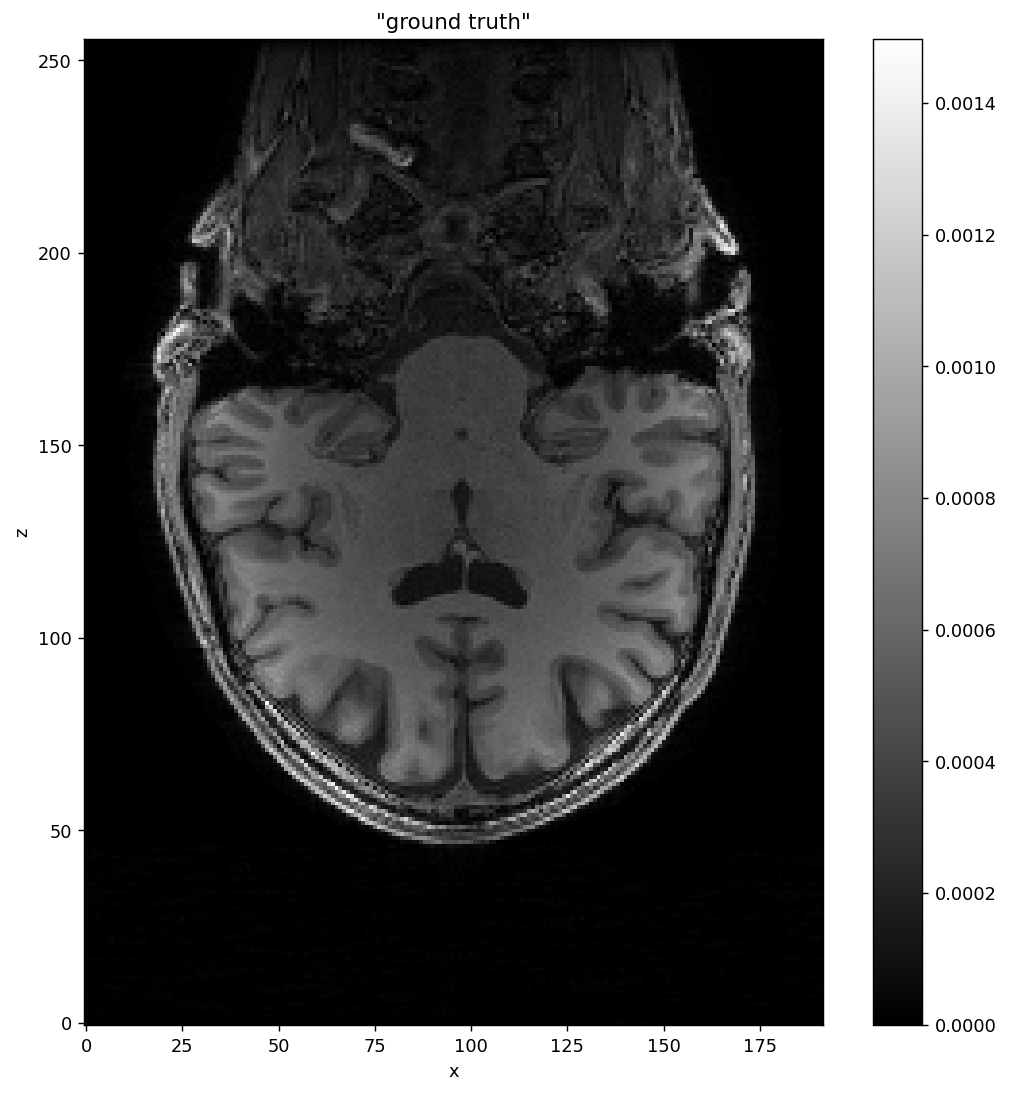

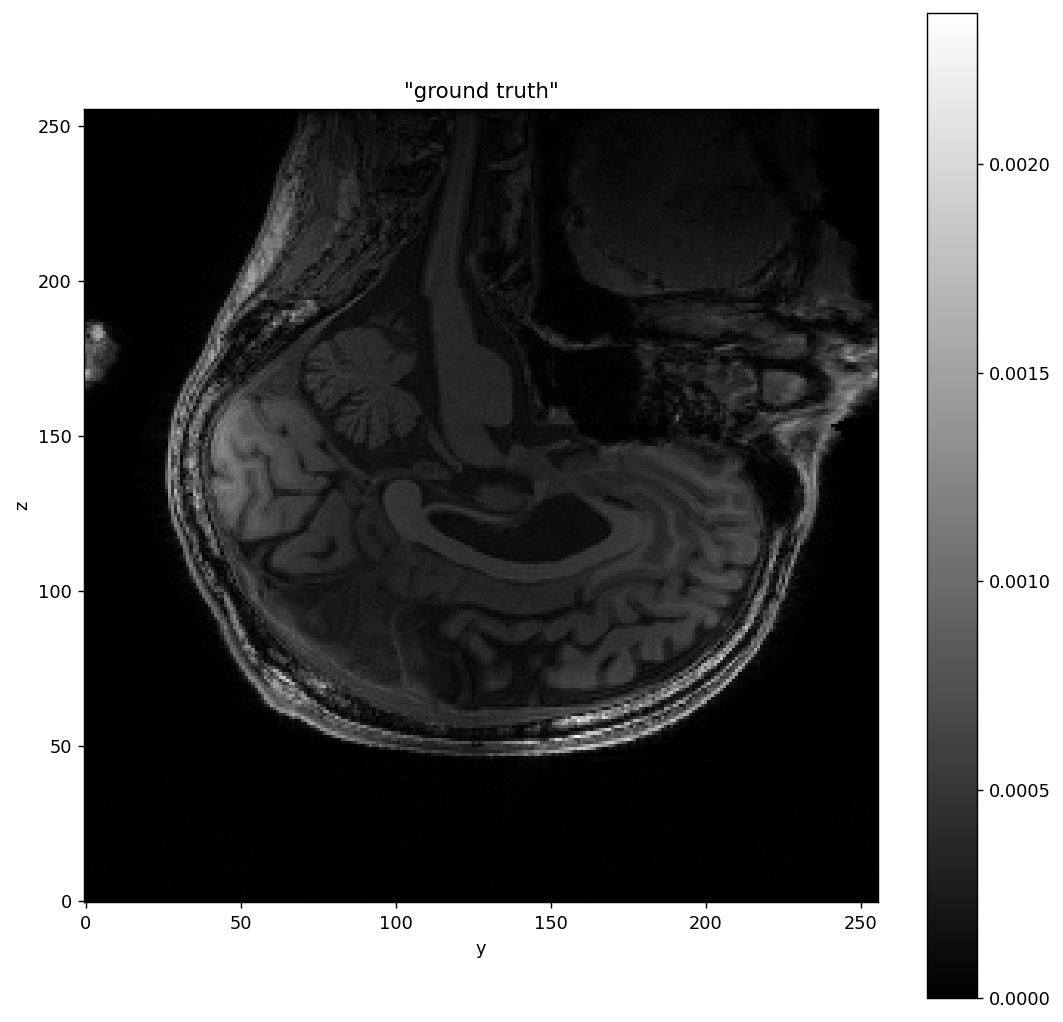

In [13]:
# make ground truth image from fully sampled k-space
if dataType == '2D':
    img_gt = np.sum(np.conj(mps) * sp.ifft(ksp, axes=(-1, -2)), axis=0)
    img_gt /= np.linalg.norm(img_gt)

    plt.figure()
    plt.imshow(np.abs(img_gt), cmap='gray', origin='lower')
    plt.title('"ground truth"')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()
    
elif dataType == '3D':
    img_gt = np.sum(np.conj(mps) * sp.ifft(ksp, axes=(-1, -2, -3)), axis=0)
    img_gt /= np.linalg.norm(img_gt)
    mid3views(np.abs(img_gt), '"ground truth"')

## SENSE Recon

With the sensitivity maps ready, we can now run a SENSE reconstruction using the [SenseRecon](https://sigpy.readthedocs.io/en/latest/generated/sigpy.mri.app.SenseRecon.html#sigpy.mri.app.SenseRecon) `App`. We will use an l2 regularization of 0.01 based on trial-and-error with this dataset. Feel free to change it!

Again, we can run the reconstruction on GPU if we specify the `device` option.

100%|██████████| 256/256 [09:52<00:00,  2.31s/it]


Time elapsed : 606.3189580440521


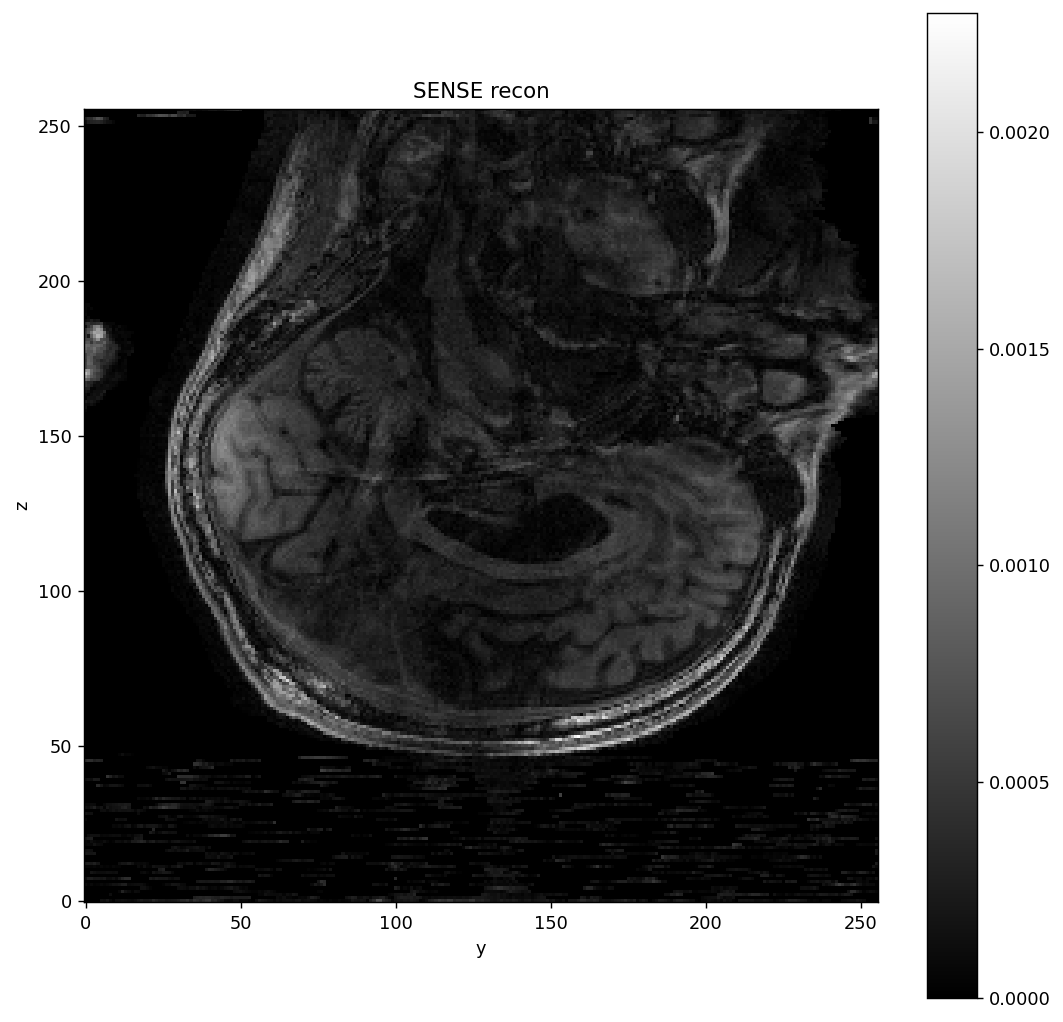

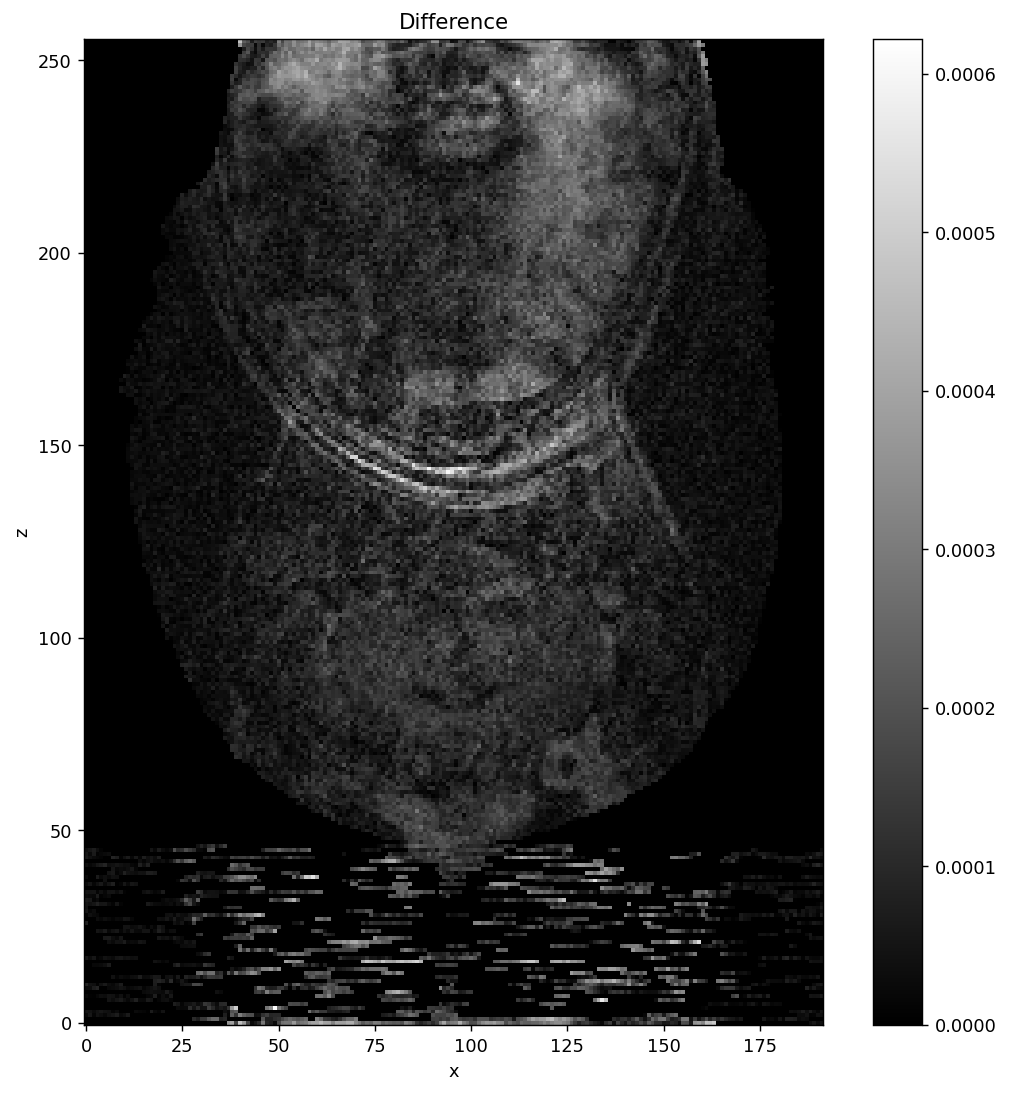

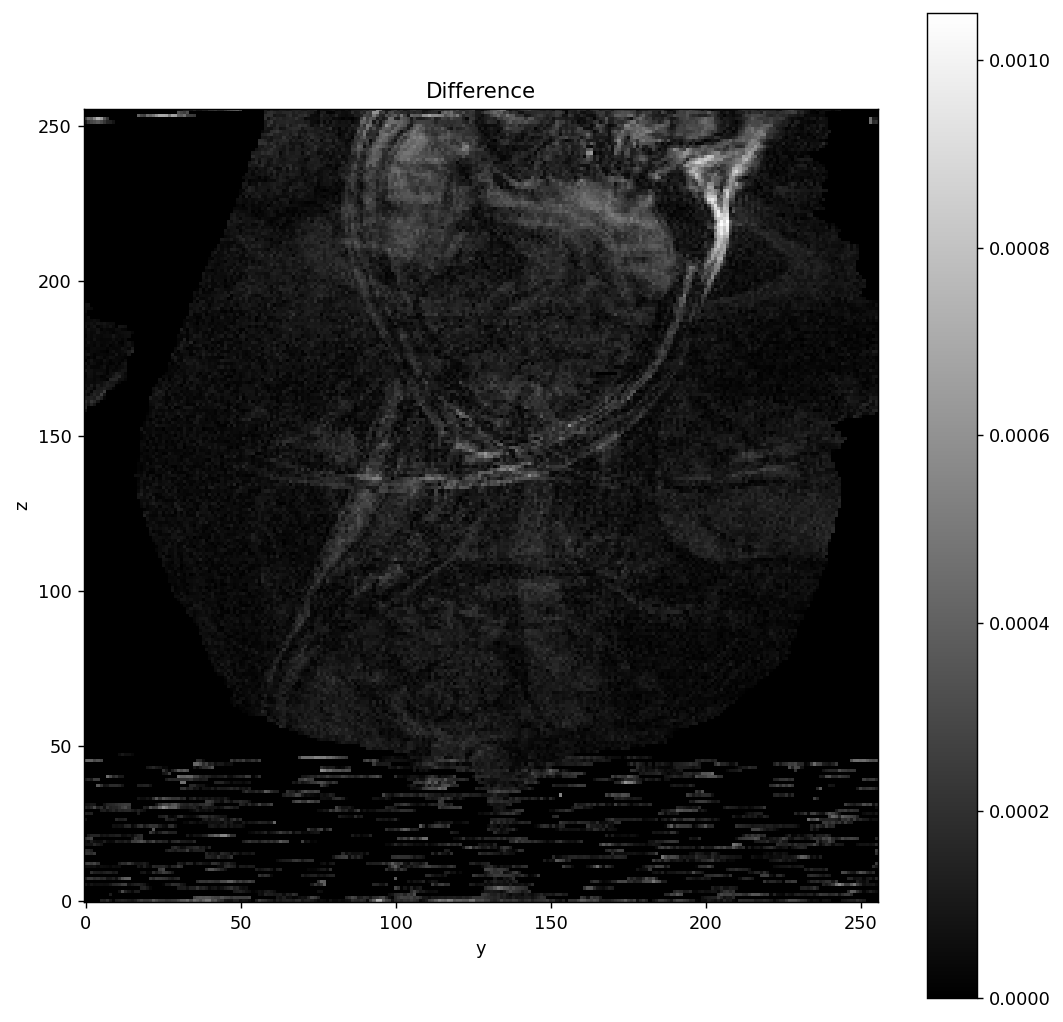

In [15]:
lamda = 0.01
start = time.time()
img_sense = np.zeros_like(img_gt)
hybrid_ksp_us = sp.ifft(ksp_us,axes=(1,))
for z in tqdm.trange(Nz):
        img_sense[z,:,:] = mr.app.SenseRecon(hybrid_ksp_us[:,z,:,:], mps[:,z,:,:],
                                            lamda=lamda, device=gpu_id, show_pbar=False
                                            ).run().get()
end = time.time()
print(f'Time elapsed : {end - start}')
img_sense /= np.linalg.norm(img_sense)

if dataType == '2D':
    plt.figure()
    plt.imshow(np.abs(img_sense), cmap='gray', origin='lower')
    plt.title('SENSE recon')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()

    plt.figure()
    plt.imshow(np.abs(img_sense - img_gt), cmap='gray', origin='lower')
    plt.title('Difference')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()
    
elif dataType == '3D':
    mid3views(np.abs(img_sense), 'SENSE recon')
    mid3views(np.abs(img_sense - img_gt), 'Difference')

# 3D times:
# Quickstep GPU: 606 s

## L1 Wavelet Regularized Reconstruction

Similarly, we can perform an l1-wavelet regularized reconstruction using [L1WaveletRecon](https://sigpy.readthedocs.io/en/latest/generated/sigpy.mri.app.L1WaveletRecon.html#sigpy.mri.app.L1WaveletRecon).

100%|██████████| 256/256 [16:44<00:00,  3.92s/it]


Time elapsed: 1019.1871428489685


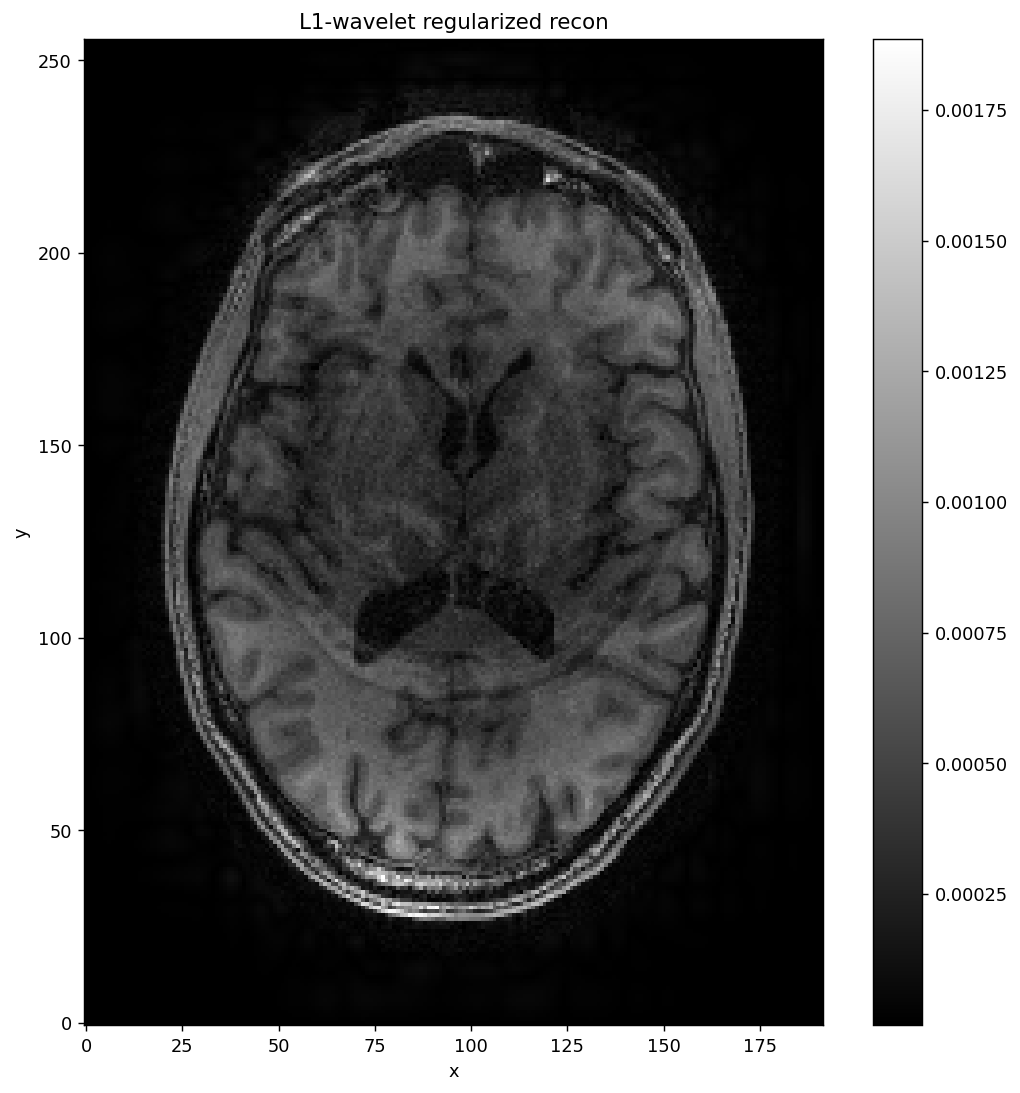

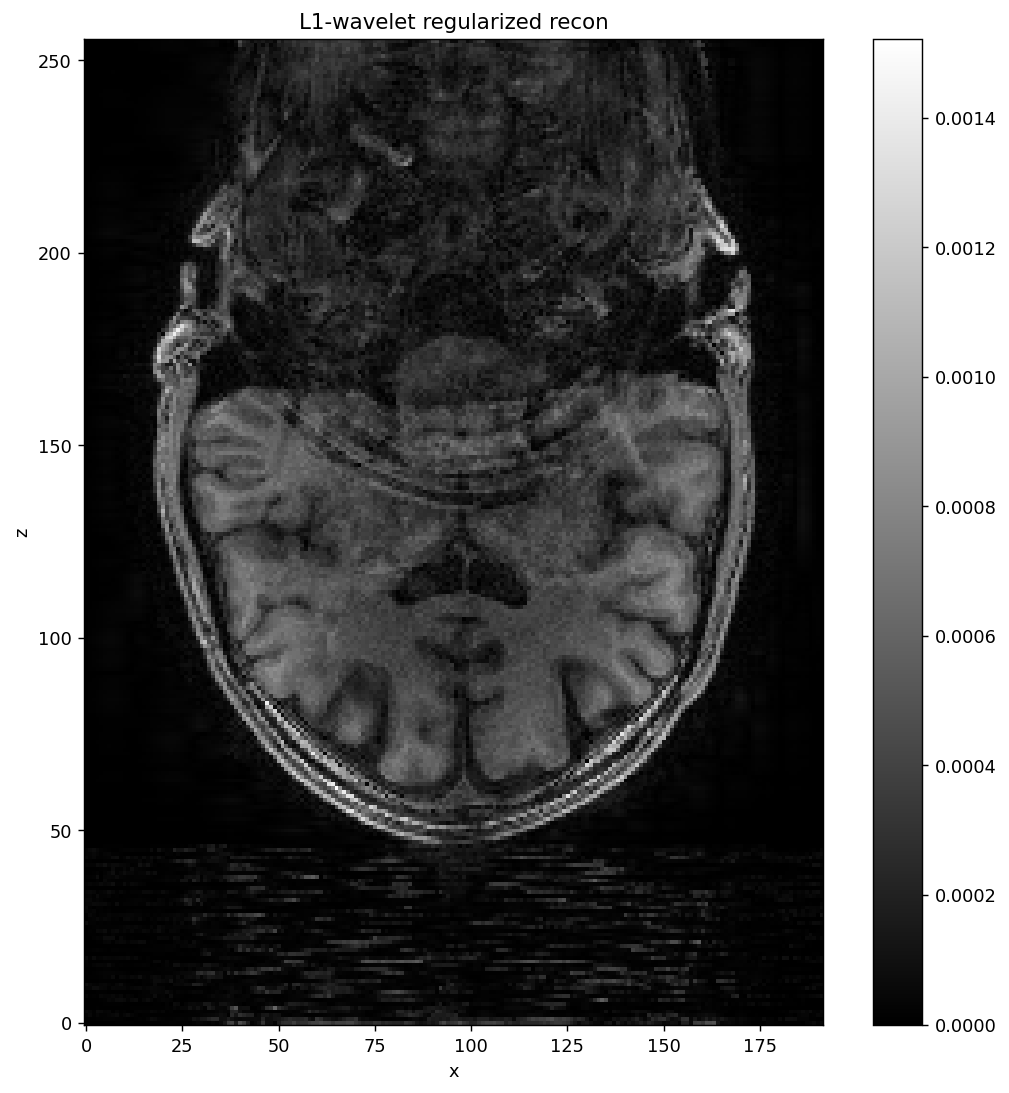

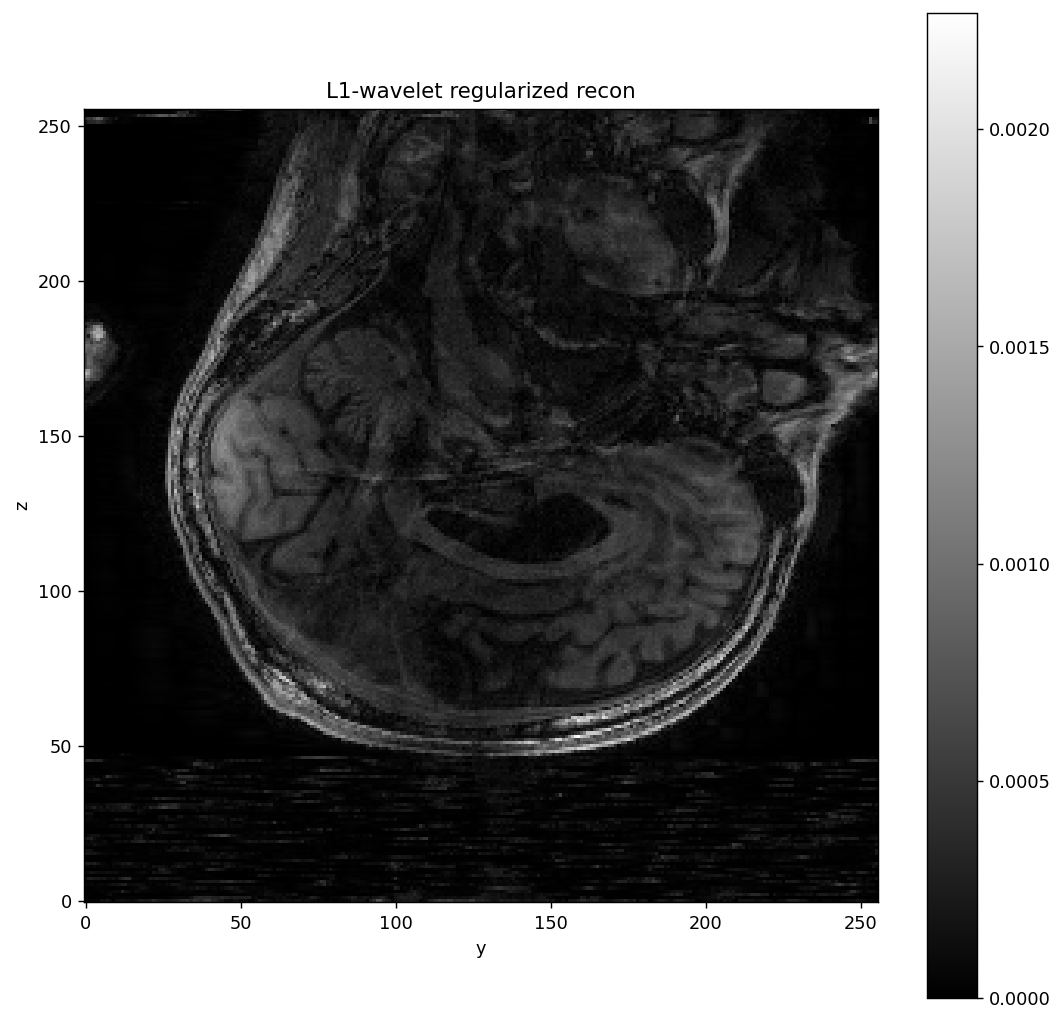

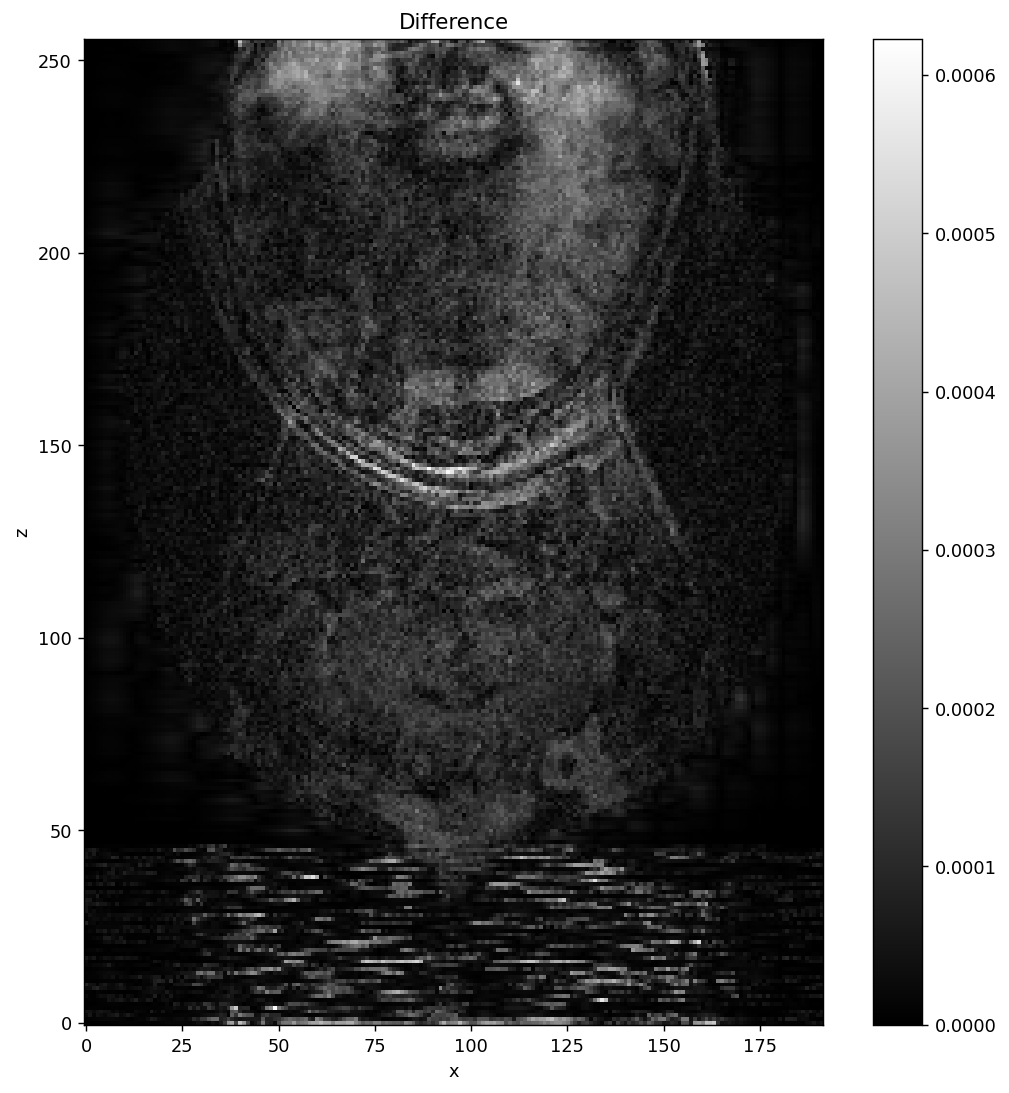

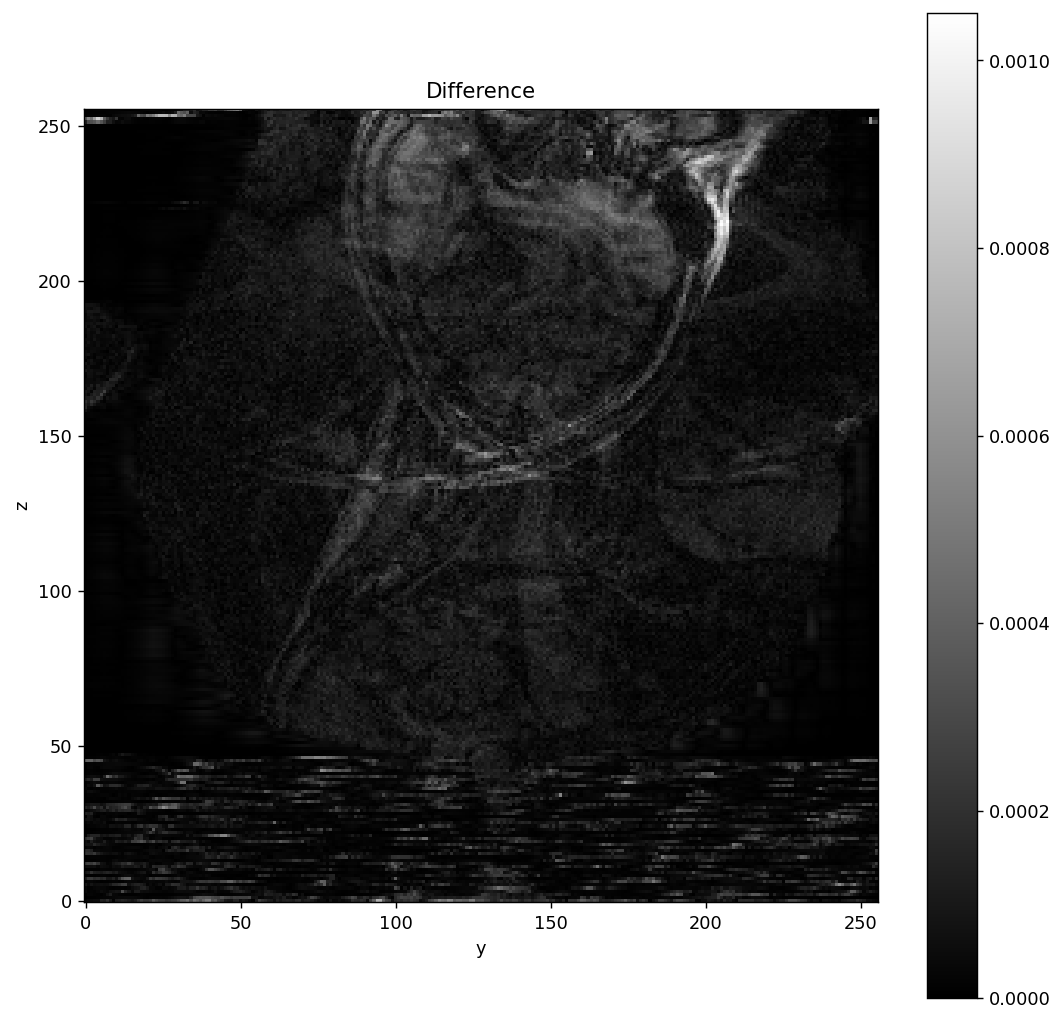

In [16]:
lamda = 0.01
start = time.time()
img_l1wav = np.zeros_like(img_gt)
hybrid_ksp_us = sp.ifft(ksp_us,axes=(1,))
for z in tqdm.trange(Nz):
        img_l1wav[z,:,:] = mr.app.L1WaveletRecon(hybrid_ksp_us[:,z,:,:], mps[:,z,:,:],
                                            lamda=lamda, device=gpu_id, show_pbar=False
                                            ).run().get()
end = time.time()
print(f'Time elapsed: {end - start}')
img_l1wav /= np.linalg.norm(img_l1wav)

if dataType == '2D':
    plt.figure()
    plt.imshow(np.abs(img_l1wav), cmap='gray', origin='lower')
    plt.title('L1-wavelet regularized recon')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()

    plt.figure()
    plt.imshow(np.abs(img_l1wav - img_gt), cmap='gray', origin='lower')
    plt.title('Difference')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()

elif dataType == '3D':
    mid3views(np.abs(img_l1wav), 'L1-wavelet regularized recon')
    mid3views(np.abs(img_l1wav - img_gt), 'Difference')

# 3D times:
# Quickstep CPU: 12 m 3 s
# Quickstep GPU: 34 s

# Total Variation Recon

And we can do total variation regularized reconstruction with [TotalVariationRecon](https://sigpy.readthedocs.io/en/latest/generated/sigpy.mri.app.TotalVariationRecon.html#sigpy.mri.app.TotalVariationRecon).

100%|██████████| 256/256 [13:43<00:00,  3.22s/it]


Time elapsed: 838.7438175678253


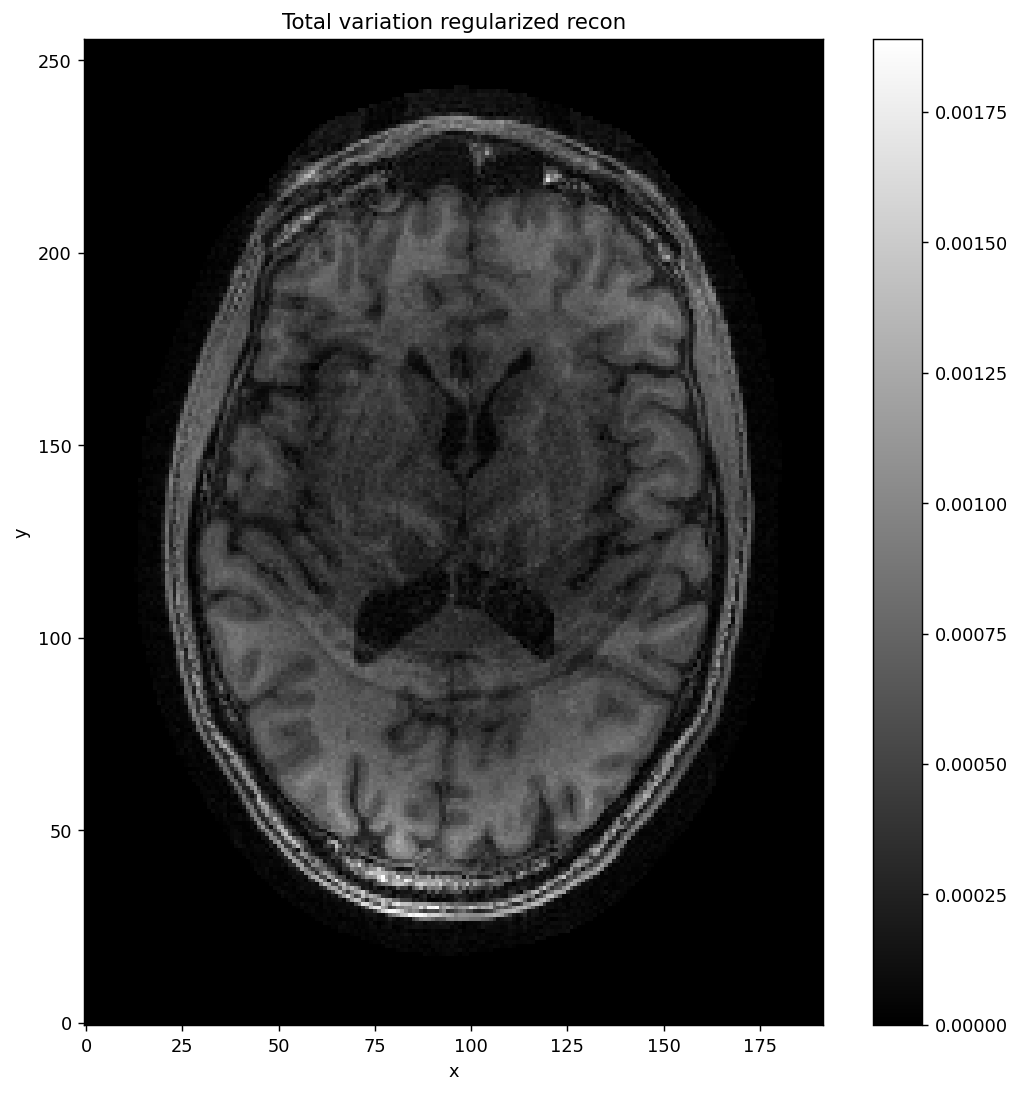

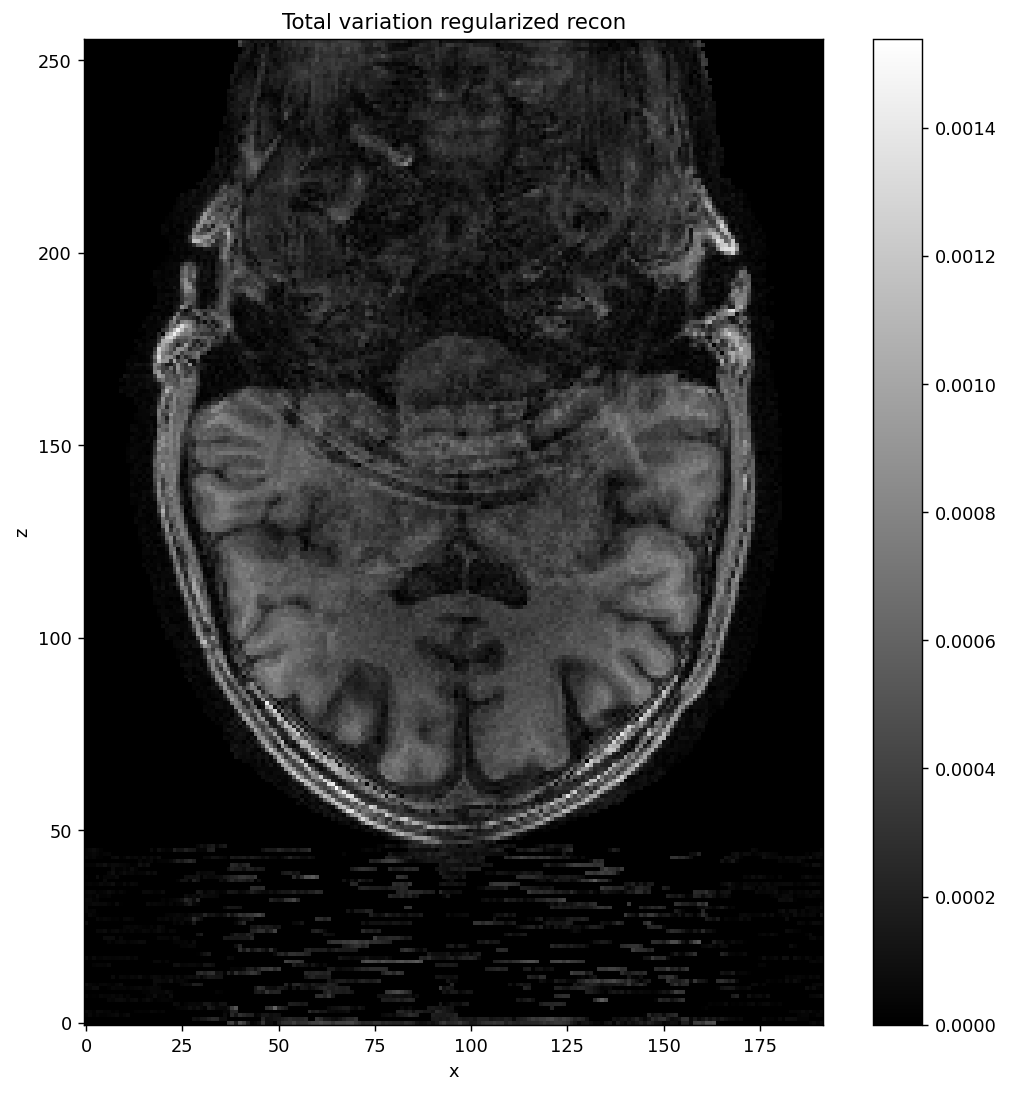

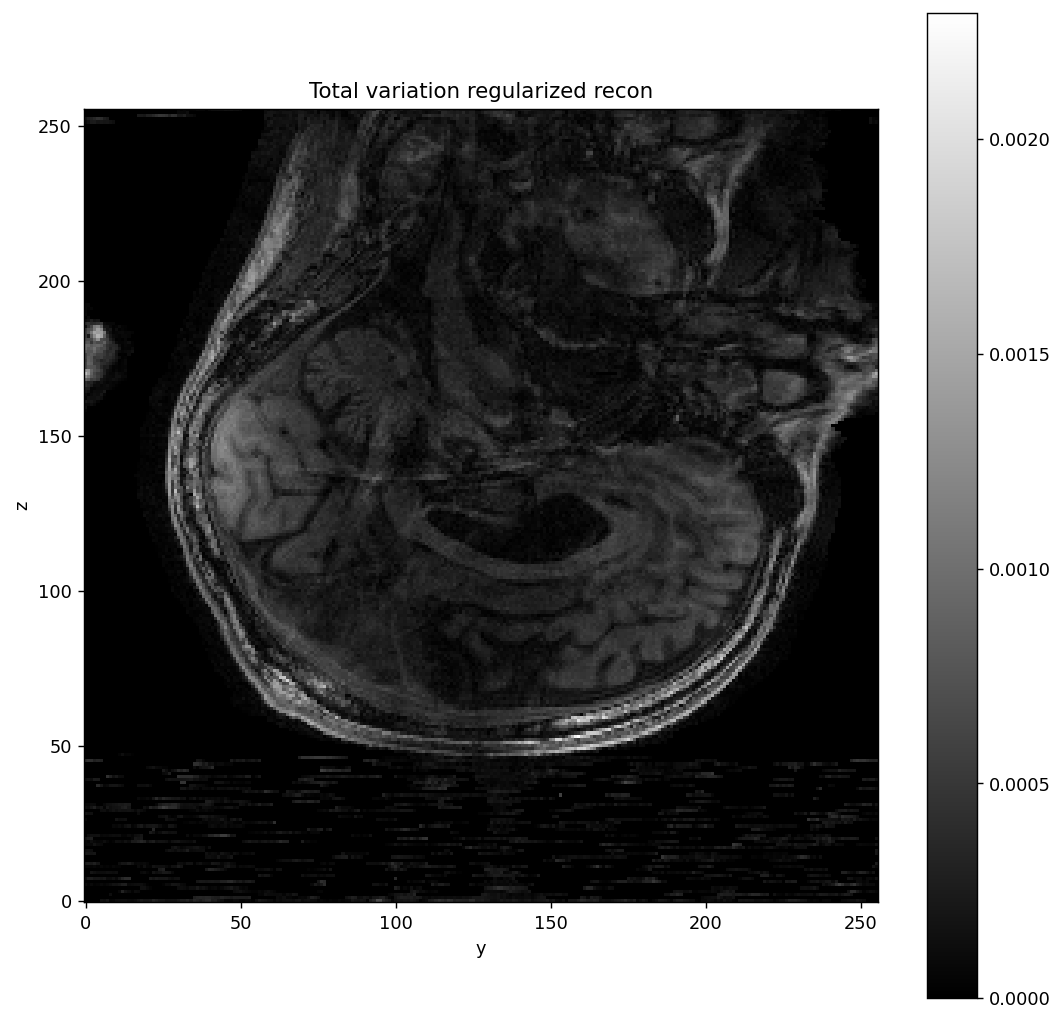

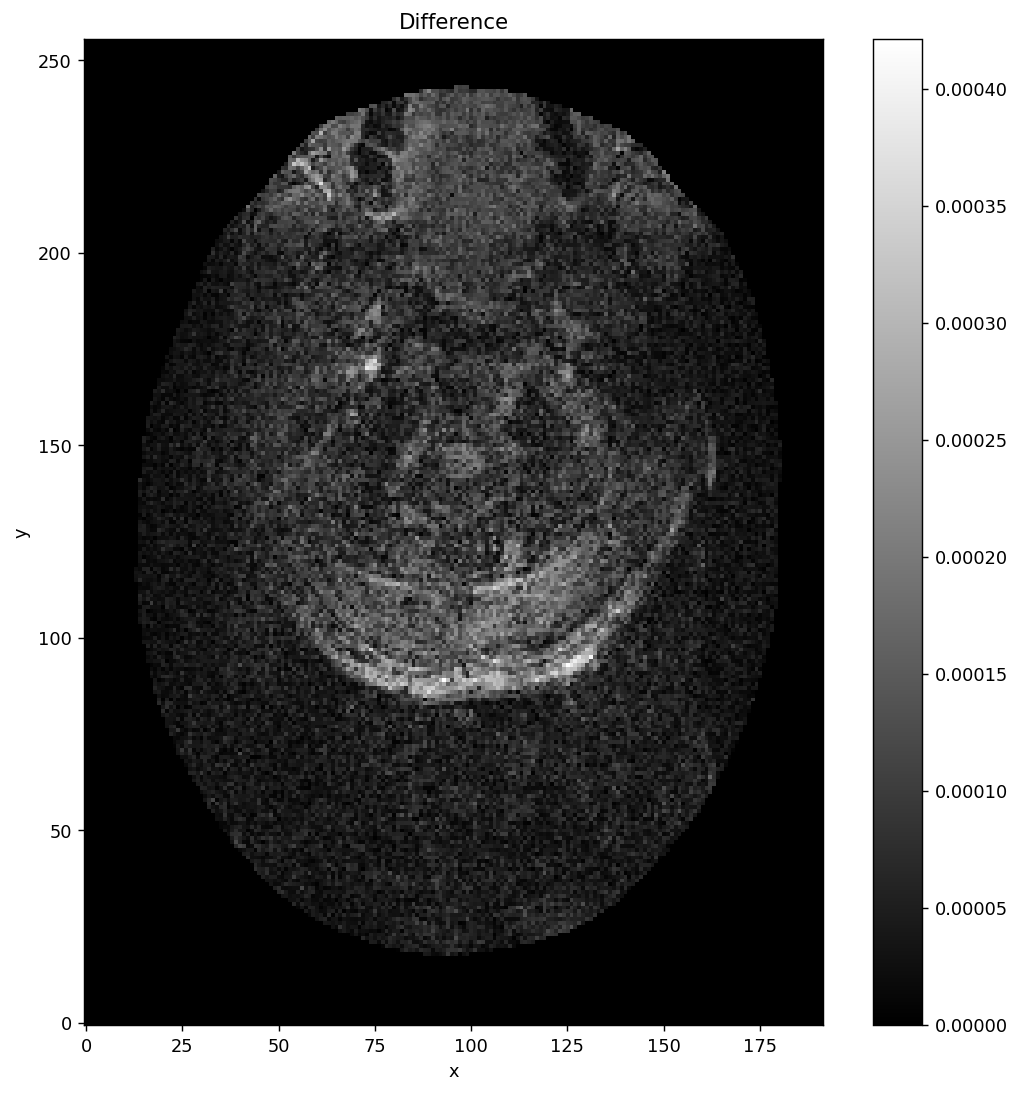

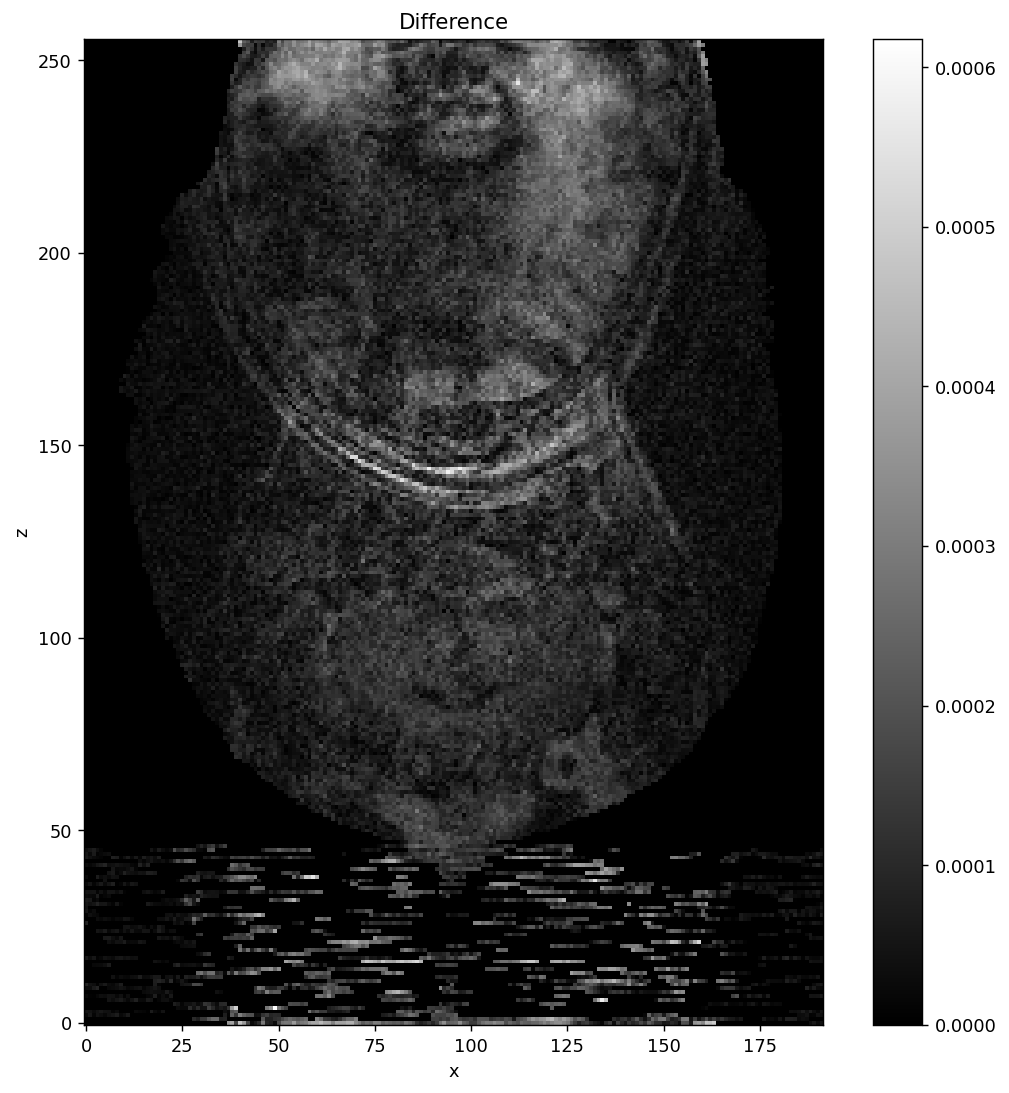

In [28]:
gpu_id = 0 # only works on gpu 0 for some reason

lamda = 1e-5
start = time.time()
img_tv = np.zeros_like(img_gt)
hybrid_ksp_us = sp.ifft(ksp_us,axes=(1,))
for z in tqdm.trange(Nz):
        img_tv[z,:,:] = mr.app.TotalVariationRecon(hybrid_ksp_us[:,z,:,:], mps[:,z,:,:],
                                            lamda=lamda, device=gpu_id, show_pbar=False
                                            ).run().get()
end = time.time()
print(f'Time elapsed: {end - start}')
img_tv /= np.linalg.norm(img_tv)

if dataType == '2D':
    plt.figure()
    plt.imshow(np.abs(img_tv), cmap='gray', origin='lower')
    plt.title('Total variation regularized recon')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()

    plt.figure()
    plt.imshow(np.abs(img_tv - img_gt), cmap='gray', origin='lower')
    plt.title('Difference')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()

elif dataType == '3D':
    mid3views(np.abs(img_tv), 'Total variation regularized recon')
    mid3views(np.abs(img_tv - img_gt), 'Difference')

# 3D times:
# Quickstep CPU: 14 m 48 s
# Quickstep GPU: 838 s